# Analiza profilu klienta

Dane, których używamy pochodzą z książki "Dane inteligentne" Johna Foremana. 

Zbiór danych zawiera zarówno informacje 

* o marketingowych kampaniach e-mailowych (wysłane oferty e-mail), 
* jak i dane o poziomie transakcji od klientów (na które klienci reagują i co kupili).

Firma prowadzi kampanie handlowe wysyłając do klientów oferty. 

Pobieramy dane z pliku "./WineKMC.xlsx". Co się w nich znajduje?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head(10)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,March,Prosecco,144,86,Chile,False
6,7,March,Prosecco,6,40,Australia,True
7,8,March,Espumante,6,45,South Africa,False
8,9,April,Chardonnay,144,57,Chile,False
9,10,April,Prosecco,72,52,California,False


i dane o ilości transakcji poszczegulnych osób

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head(10)

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1
5,Williams,18,1
6,Williams,22,1
7,Williams,31,1
8,Brown,7,1
9,Brown,29,1


Czego dotyczą dane? 

Są to wystawione oferty sprzedaży win (pierwsza karta) oraz informacja o transakcjach dokonanych przez poszczególnych klientów (druga karta). 

  * Firma będzie tworzyć nowe oferty. 
  * Chcielibyśmy wiedzieć do których klientów skierować poszczególne oferty. 
  * Możemy założyć że klientów jest milion i nie jesteśmy w stanie rozpatrzyć każdego indywidualnie. 
  * Poza tym klient może chcieć kupić coś innego, dlatego nie możemy się kierować tylko tym co już kupił.

# Zad

Stwórzmy tabelę, gdzie 

  * w wierszach są klienci a w kolumnach oferty 
  * dla każdego klienta zaznaczmy czy wybrał daną ofertę (1) czy nie (0).

In [5]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions)
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')

In [6]:
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
# # save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]
X = matrix[x_cols]

In [7]:
# print(df)
# print("------------")
print(matrix.shape)
matrix.head()

(100, 33)


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Podzielmy klientów na grupy (segmenty) - do jednej grupy włączamy podobnych klientów - podobni klienci reagują na podobne oferty. Użyjemy Kmeans do grupowania.

In [13]:
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5, random_state = 42)
# slice matrix so we only include the 0/1 indicator columns in the clustering
matrix['cluster'] = cluster.fit_predict(matrix[matrix.columns[2:]])

Jakie są liczności grup?

In [14]:
matrix.cluster.value_counts()

1    35
0    22
4    17
2    17
3     9
Name: cluster, dtype: int64

Mozemy zwizualizować wynik na płaszczyźnie 
* t-SNE
* PCA

In [15]:
X.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


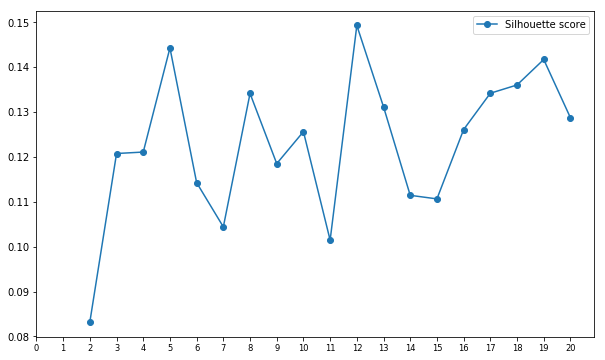

In [16]:
from sklearn.metrics import silhouette_score

silhouette_score_array = [None, None]
    
for i in range(2,21):
    km = KMeans(n_clusters=i, n_init=10)
    y_km = km.fit_predict(X)
    silhouette_score_array.append( silhouette_score(X,km.labels_) )
    
t=range(0,21)

plt.figure(figsize=(10,6));
plt.plot(silhouette_score_array, "o-", label="Silhouette score")
plt.xticks(range(len(t)), t, size='small')
plt.legend()
plt.show()

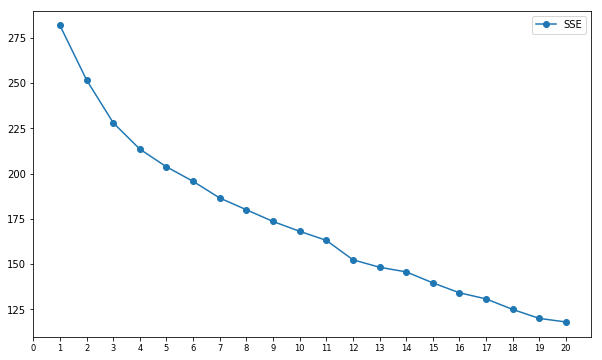

In [19]:
SSE_array = [None]
    
for i in range(1,21):
    km = KMeans(n_clusters=i, n_init=10)
    y_km = km.fit_predict(X)
    SSE_array.append(km.inertia_)
    
t=range(0,21)

plt.figure(figsize=(10,6));
plt.plot(SSE_array, "o-", label="SSE")
plt.xticks(range(len(t)), t, size='small')
plt.legend()
plt.show()    

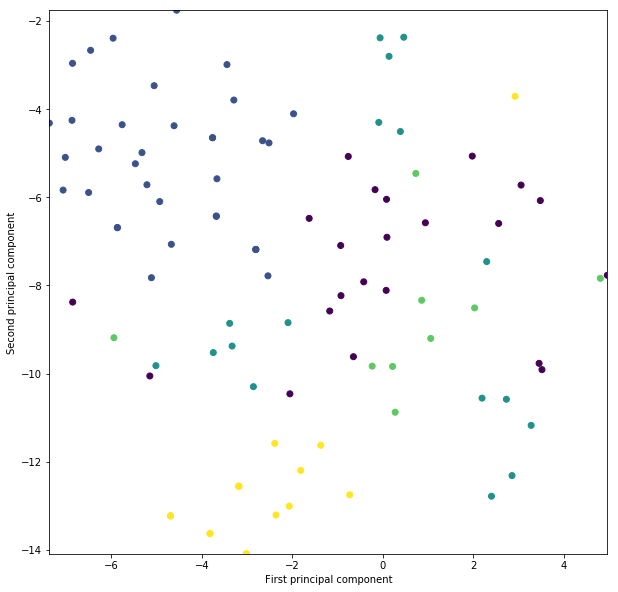

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
X_tsne = tsne.fit_transform(X)

from matplotlib import colors as mcolors
#colors = list(mcolors.CSS4_COLORS)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]

plt.figure(figsize=(10, 10))
plt.xlim(X_tsne[:, 0].min(), X_tsne[:, 0].max())
plt.ylim(X_tsne[:, 1].min(), X_tsne[:, 1].max())
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = cluster.labels_)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

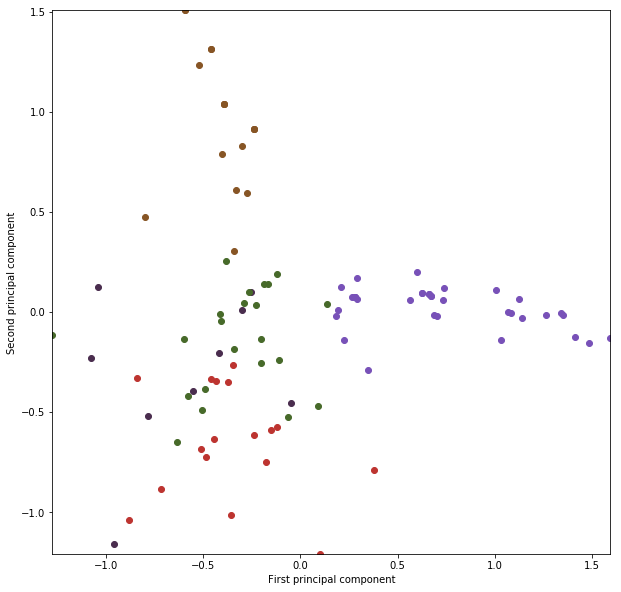

In [18]:
from sklearn.decomposition import PCA

# build a PCA model
pca = PCA(n_components=2)
pca.fit(X)
# transform the digits data onto the first two principal components
X_pca = pca.transform(X)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(X_pca[:, 0].min(), X_pca[:, 0].max())
plt.ylim(X_pca[:, 1].min(), X_pca[:, 1].max())
for i in range(len(X)):
    # actually plot the digits as text instead of using scatter
    plt.scatter(X_pca[i, 0], X_pca[i, 1], color = colors[cluster.labels_[i]])
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

Zanalizujmy ostatni klaster.

ZADANIE: Dla każdego wina wylistować ilość klientów które go kupili - z klastra 4 i z innych klastrów. 

In [10]:
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [11]:
matrix.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,cluster
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [12]:
df['is_4'] = matrix['cluster']==4
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,is_4
0,1,January,Malbec,72,56,France,False,Thomas,1,False
1,1,January,Malbec,72,56,France,False,Jackson,1,False
2,1,January,Malbec,72,56,France,False,Mitchell,1,True
3,1,January,Malbec,72,56,France,False,Peterson,1,False
4,1,January,Malbec,72,56,France,False,Wood,1,False


In [13]:
df.groupby("is_4").varietal.value_counts()

is_4   varietal          
False  Prosecco              26
       Espumante             22
       Champagne             11
       Malbec                 8
       Chardonnay             7
       Pinot Noir             7
       Cabernet Sauvignon     2
True   Prosecco               5
       Espumante              4
       Pinot Noir             3
       Cabernet Sauvignon     2
       Malbec                 2
       Champagne              1
Name: varietal, dtype: int64

Które wino jest kupowane tylko przez ten klaster, a które wcale?

Spójrzmy na numeryczne atrybuty. Jak jest średnia ilości i rabatu?

In [15]:
df.groupby("is_4")[['min_qty', 'discount']].mean()

,min_qty,discount
is_4,,
False,66.578313,48.277108
True,69.882353,44.588235


Czy ci klienci kupują duże czy małe ilości?

In [16]:
df.groupby("is_4")[['min_qty', 'discount']].std()

,min_qty,discount
is_4,,
False,56.925737,17.365731
True,56.997678,19.697902
